# Vanilla Neural Network

This does what it says it does. Implements a basic NN with sigmoid activations and a L2 cost function. Mostly based on the equations from [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap2.html#the_four_fundamental_equations_behind_backpropagation) and [my notes](https://ahiru.pl/notes/backpropagation/).

PyTorch is used here mainly as a numpy wrapper, seeing as batch handling is done manually. That being said, it learns MNIST digits, which is pretty much all this was supposed to do.

In [2]:
import random
from datetime import datetime

import torch
import numpy as np
import fastbook
from torch import tensor

import mnist
from monitoring import graph_updater
from math_funcs import is_correct, L2, Sigmoid


fastbook.setup_book()     

training_set, testing_set, validation_set = mnist.datasets(0.8)

In [4]:
class Network:
    def __init__(self, layers, nonlinearity=Sigmoid(), cost_func=L2()):
        # This assumes that each layer will use the same nonlinearity. Seems
        # like a good enough heuristic for now
        self.nonlinearity = nonlinearity
        self.cost_func = cost_func
        self.w = [torch.rand(n_out, n_in) / torch.sqrt(tensor(n_in)) for n_in, n_out in zip(layers, layers[1:])]
        self.b = [torch.rand(n_out, 1) for n_out in layers[1:]]
        
    def forward(self, inputs):
        """Do a forward pass and return all the activations for each layer.
        
        The inputs will be the first element of the activations.
        The actual output of the network is the last element of the resulting list.
        """
        a = inputs
        activations = [a]
        for w, b in zip(self.w, self.b):
            a = self.nonlinearity(w @ a + b)
            activations.append(a)
        return activations
         
    def step(self, inputs):
        """"Get the outputs from running the given `inputs` through the network."""
        return self.forward(inputs)[-1]
    
    def gradient(self, activations, expected):
        """Calculate the gradient(s).
        
        :param list activations: a list of per layer activations from the forward pass
        :param tensor expected: the expected output of the network, i.e. the label for
                                the inputs
        :returns: a list of per layer (dw, db) gradients, from the first layer to the last
        
        Seeing as it uses pytorch, either single items, or tensors of items can be
        provided.
        
        This is based on http://neuralnetworksanddeeplearning.com/chap2.html#the_four_fundamental_equations_behind_backpropagation
        and https://ahiru.pl/notes/backpropagation/ 
        """
        layer_gradients = []
       
        # Calculate the gradients for the final layer, which is
        # different from the rest in that it's based directly on
        # The cost function, as opposed to the error of a later
        # layer
        in_ = activations[-2]
        out = activations[-1]

        nabla_C = self.cost_func.deriv(out, expected)
        sigma_L = self.nonlinearity.deriv(out)
        delta_L = nabla_C * self.nonlinearity.deriv(out)

        prev_delta = delta_L
        
        dw = prev_delta @ torch.transpose(in_, 0, 1) 
        db = prev_delta 
        layer_gradients.append([dw, db])
        
        # Now for each layer, starting from the last-but-one and going
        # to the first one, calculate the gradients of the weights and
        # biases
        for l in range(len(self.w) - 2, -1, -1):
            in_ = activations[l]
            out = activations[l+1]
            
            delta_l = (torch.transpose(self.w[l+1], 0, 1) @ prev_delta) * self.nonlinearity.deriv(out)
            prev_delta = delta_l
            
            dw = delta_l @ torch.transpose(in_, 0, 1)
            db = delta_l
            
            layer_gradients.append([dw, db])
        
        # The `layer_gradients` list is from the last to first layer,
        # so reverse it
        return list(reversed(layer_gradients))
    
    def update(self, gradient, lr):
        # For each layer of the gradient list, update the
        # weights and biases for that layer
        for i, (w, b) in enumerate(gradient):
            self.w[i] -= lr * w
            self.b[i] -= lr * b
            
    def cost(self, expected, output):
        """Calculate the cost between the label and what the network predicted."""
        return self.cost_func(expected, output)
        

In [3]:
# The gradients are collected per input, but they should be applied per batch. These
# functions mangle the gradient lists from [<grad 1>, <grad 2>, ...] to 
# [<mean grad for layer 1>, <mean grad for layer 2>, ...]

def merge_layer_grads(grads):
    return [torch.stack(i).mean(0) for i in zip(*grads)]
    

def merge_grads(grads):
    return [merge_layer_grads(l) for l in zip(*grads)]

In [9]:
def run_epoch(network, dataset, lr):
    accuracy = []
    costs = []
    
    for batch in iter(dataset):
        grads = []
        for xs, expected in zip(*batch):
            activations = network.forward(xs)
            output = activations[-1]
            grad = network.gradient(activations, expected)
            grads.append(grad)
            
            cost = network.cost(expected, output)
            
            accuracy.append(is_correct(expected, output))
            costs.append(cost)
         
        grad = merge_grads(grads)
        network.update(grad, lr)

    return tensor(accuracy).float().mean(), torch.stack(costs).mean()


def train(network, dataset, epochs, lr, show_progress=True):
    if show_progress:
        add_datapoint = graph_updater()
    
    for epoch in range(epochs):
        start = datetime.now()
        
        avg_accuracy, avg_cost = run_epoch(network, dataset, lr)
        
        if show_progress and (not epoch % 1):
            print(f'epoch {epoch}: accuracy={round(avg_accuracy.item(), 3)}, cost={round(avg_cost.item(), 3)}, time: {datetime.now() - start}')
            add_datapoint(avg_accuracy)
    
    return avg_accuracy, avg_cost

In [12]:
n = Network((28*28, 50, 10))

(tensor(0.8565), tensor(0.1154))

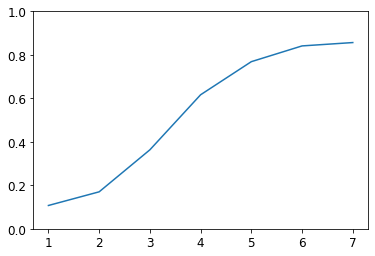

In [13]:
train(n, training_set, epochs=7, lr=3)